## NOTE: all the algorithms should start with this code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
houses = ['A', 'B', 'C']
xtype_dict = {'r':'raw', 'c':'change'}

In [3]:
def read_data(house, xtype):
    assert house in houses
    assert xtype in xtype_dict
    
    act_df = pd.read_csv("data/house{}_act.csv".format(house))
    sensor_df = pd.read_csv("data/house{}_sensor.csv".format(house))
    X = np.load("data/X_{}_house{}.npy".format(xtype_dict[xtype], house))
    Y = np.load("data/Y_house{}.npy".format(house))
    return act_df, sensor_df, X, Y

# Example

# Prior A

In [9]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('A', 'r')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
#e.g. print something
print "# sensors: ", len(all_sensor)
print "# states/acts (including unknown): ", len(all_act)
print "# timeframes: ", len(X)
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
i2m = {}
for i in range(len(all_act)):
    
    i2m[i] = set(act_df[act_df['label']==i2a[i]]['meaning'])

# sensors:  14
# states/acts (including unknown):  17
# timeframes:  40006


In [13]:
num_t = len(X)
num_act = len(all_act)

HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1*5
LIKELY = 2*5
HIGHLY_LIKELY = 3*5
VERY_LIKELY = 4 *5
ALMOST_CERTAINLY = 8*5
# six_am of starting date of house A at Amsterdam
first_zero_am = 1203894000
first_six_am = 1203915600
first_time_dict = {}
for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}

priorA = np.zeros((DAY,num_act))

first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
end_leaving = first_leaving + HOUR * (22-8)


reshape_shape = [num_t/DAY,DAY]
used_t = num_t/DAY*DAY
remain_t = num_t - used_t

used_Y = Y[:used_t]
remain_Y = Y[used_t:]
print "Used {} minutes, remains {} minutes, total {} minutes".format(used_Y.shape[0], remain_Y.shape[0], Y.shape[0])
used_Y = used_Y.reshape(reshape_shape)
for i in range(used_Y.shape[1]):
    day_activity = used_Y[:,i]
    unique, counts = np.unique(day_activity, return_counts=True)

    if i < remain_t:
        if remain_Y[i] in unique:
            counts[int(np.where(unique==remain_Y[i])[0])]+=1

        else:
            np.append(unique,int(remain_Y[i]))
            np.append(counts,1)
            print unique,counts
        for j,k in enumerate(unique):
            priorA[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0])+1)
    else:
        for j,k in enumerate(unique):
            priorA[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0]))

priorA = np.tile(priorA,(num_t/DAY,1))
priorA = np.vstack((priorA, priorA[0:remain_t]))
priorA.shape

Used 38880 minutes, remains 1126 minutes, total 40006 minutes


(40006, 17)

## Plot Prior A, Time interval

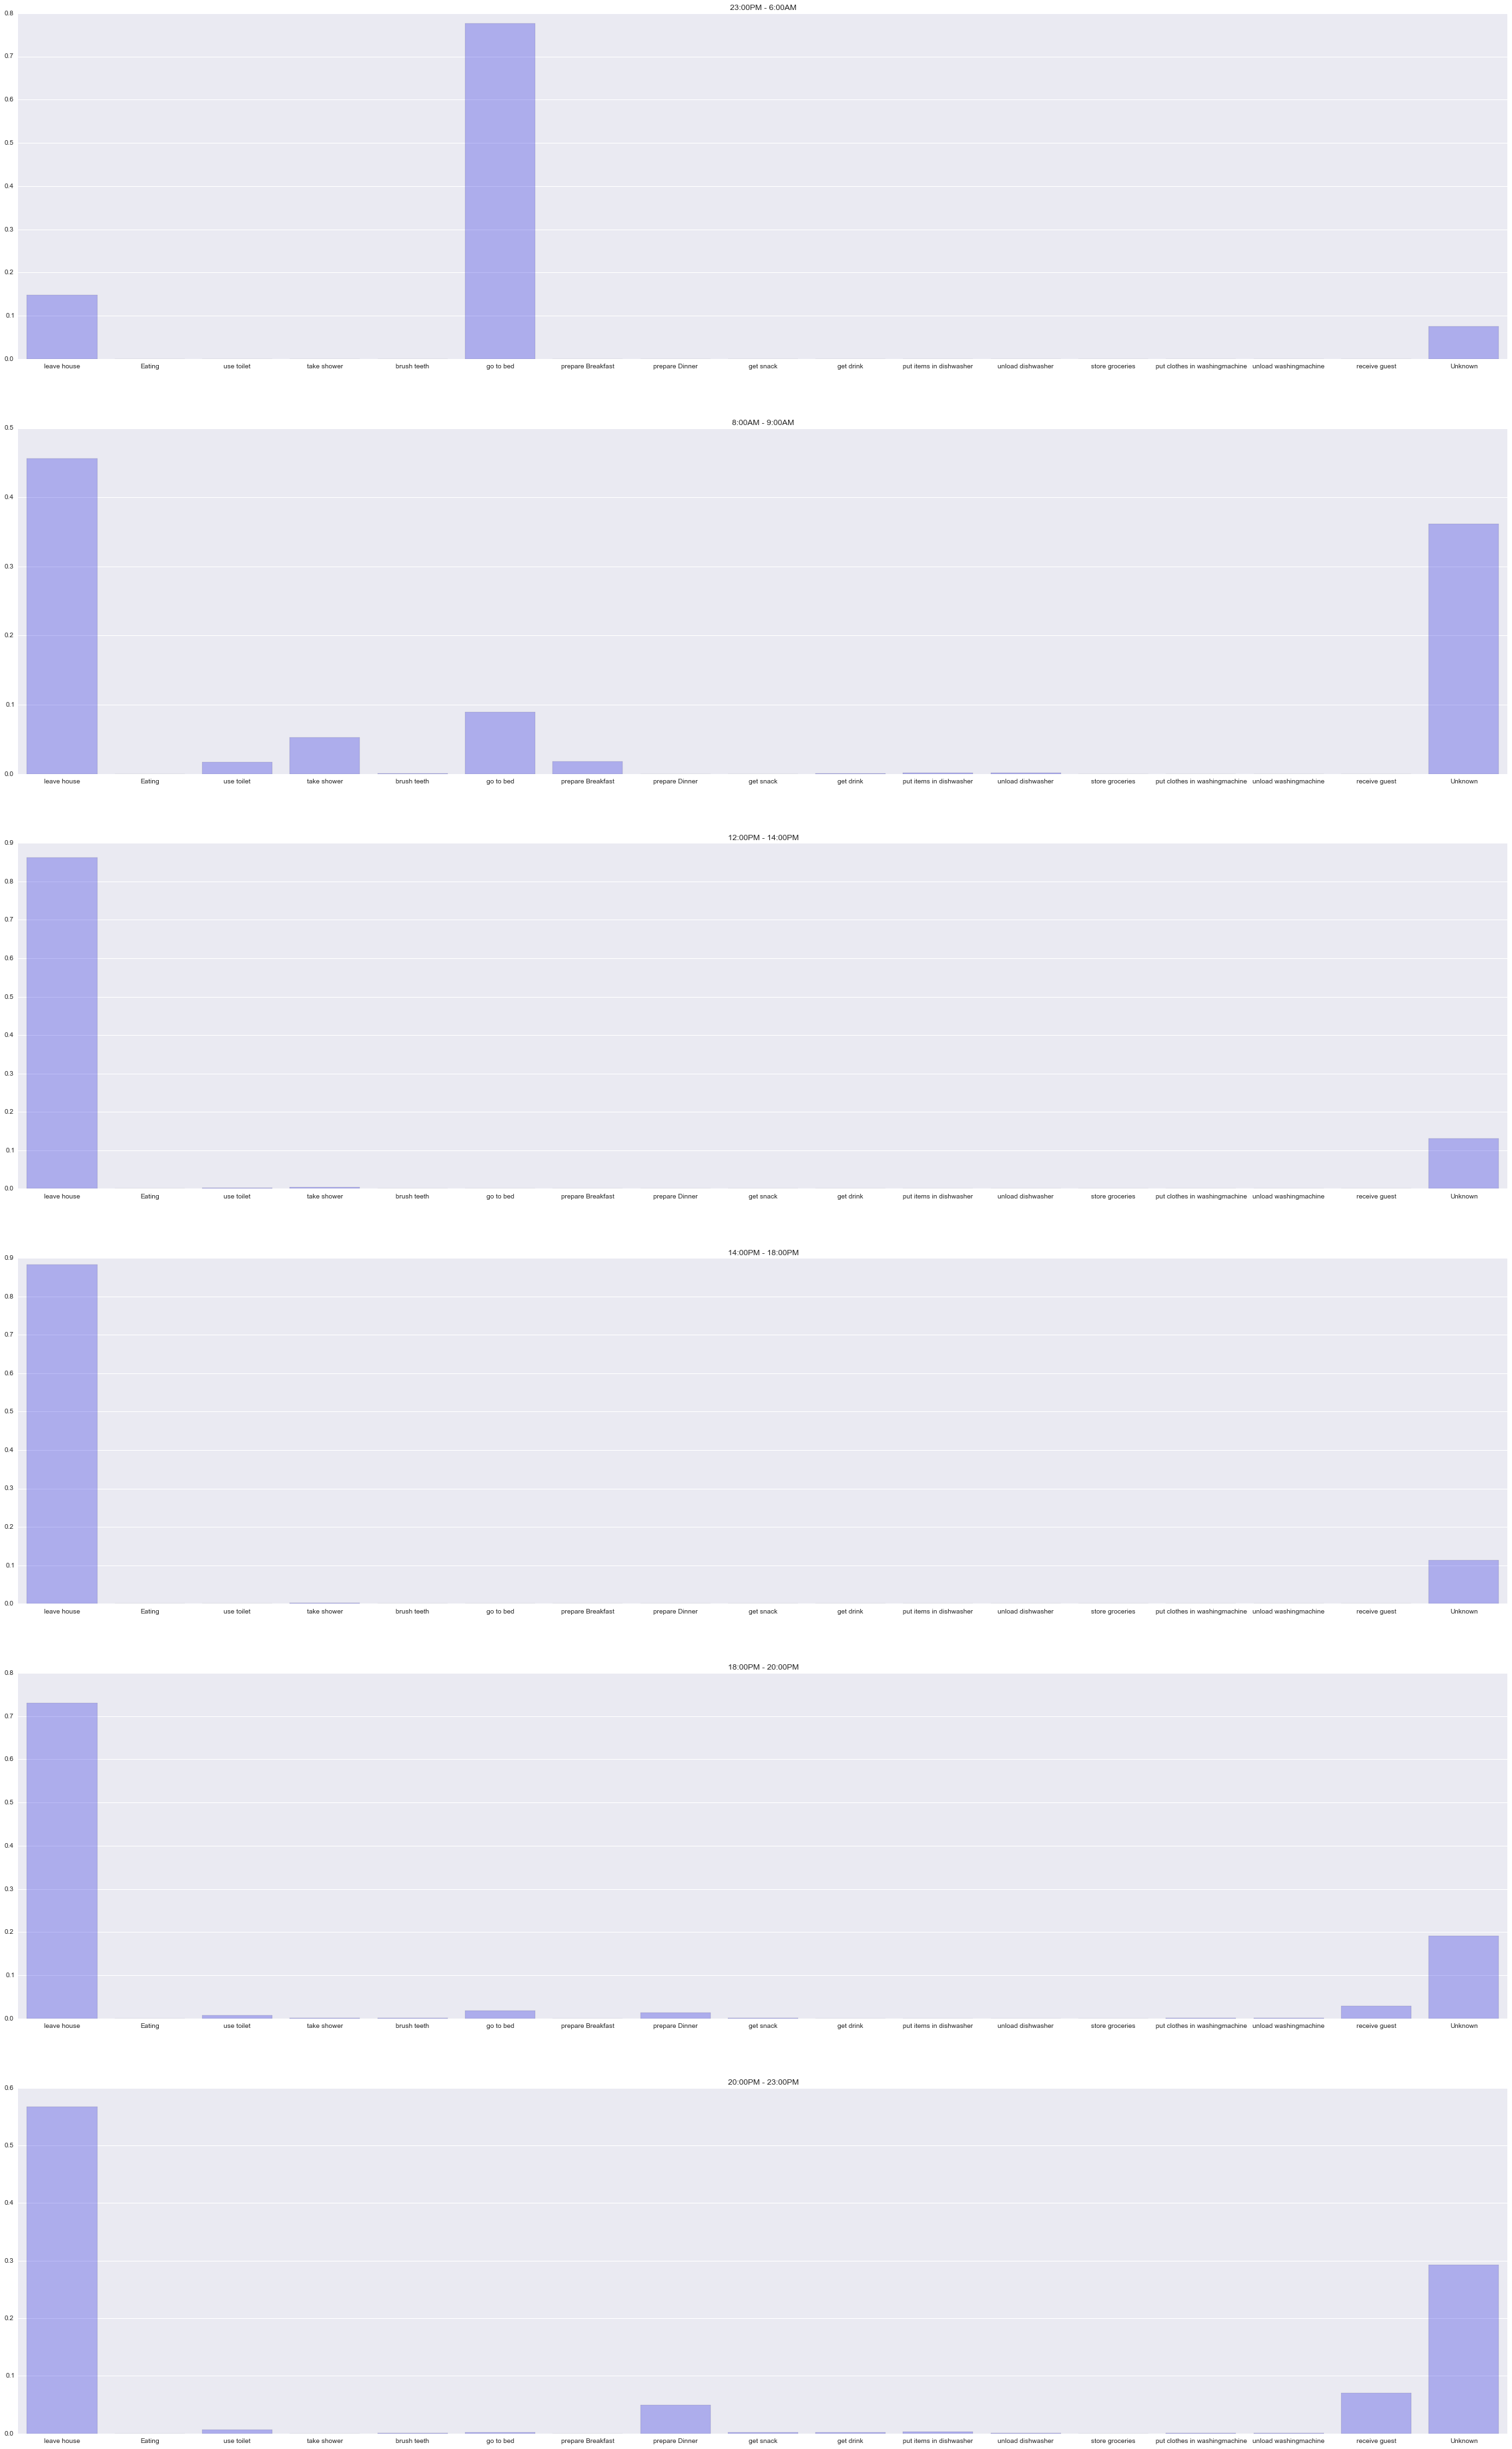

In [14]:
acts = np.arange(num_act)
fig, ax = plt.subplots(6,1,figsize = (40,65))
zero_start = first_time_dict[0]
six_am_prior = np.mean(priorA[zero_start + 23*HOUR:zero_start + DAY + 6*HOUR], axis = 0)
sns.barplot(acts,np.mean(priorA[zero_start + 7*HOUR:zero_start + 9*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[0])
sns.barplot(acts,np.mean(priorA[zero_start + 10*HOUR:zero_start + 12*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[1])
sns.barplot(acts,np.mean(priorA[zero_start + 12*HOUR:zero_start + 14*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[2])
sns.barplot(acts,np.mean(priorA[zero_start + 14*HOUR:zero_start + 18*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[3])
sns.barplot(acts,np.mean(priorA[zero_start + 18*HOUR:zero_start + 20*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[4])
sns.barplot(acts,np.mean(priorA[zero_start + 20*HOUR:zero_start + 23*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[5])

ticklist = []
for i in i2m.values():
    if i:
        ticklist.append(list(i)[0])
    else:
        ticklist.append('Unknown')
for i in range(6):
    ax[i].set_xticklabels(ticklist)
ax[0].set_title('23:00PM - 6:00AM')
ax[1].set_title('8:00AM - 9:00AM')
ax[2].set_title('12:00PM - 14:00PM')
ax[3].set_title('14:00PM - 18:00PM')
ax[4].set_title('18:00PM - 20:00PM')
ax[5].set_title('20:00PM - 23:00PM')

## Plot Prior A, Day

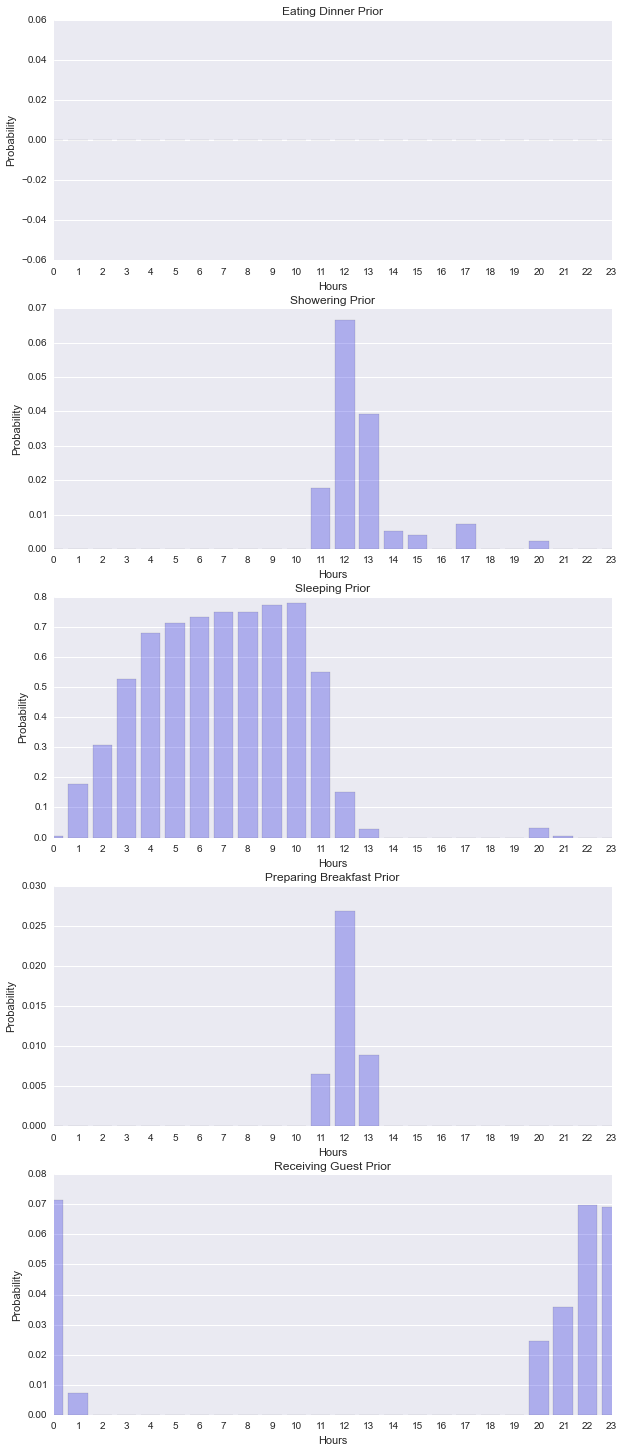

In [15]:
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
# Eating
#print ax[0]
zero_start = first_time_dict[0]
day_eating = priorA[:,1][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_eating = np.mean(day_eating,axis=1)
day_hourly_eating = np.roll(day_hourly_eating,2)
sns.barplot(day1,day_hourly_eating,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Eating Dinner Prior')

#take shower
day_showering = priorA[:,3][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorA[:,5][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_prepare_breakfast = priorA[:,6][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_prepare_breakfast = np.mean(day_prepare_breakfast,axis=1)
day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_prepare_breakfast,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Preparing Breakfast Prior')

day_guest = priorA[:,15][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_guest = np.mean(day_guest,axis=1)
day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_guest,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Receiving Guest Prior')


# Prior B

In [16]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('B', 'r')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
i2m = {}
for i in range(len(all_act)):
    i2m[i] = set(list(act_df[act_df['label']==i2a[i]]['meaning']))

In [19]:
# Prior
num_t = len(X)
num_act = len(all_act)
HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1*2
LIKELY = 2*2
HIGHLY_LIKELY = 3*2
VERY_LIKELY = 4*2
ALMOST_CERTAINLY = 8*2
#first_zero_am = 1203894000
first_six_am = 1248235200
first_time_dict = {}
#{0: 509, 1: 569, 2: 629, 3: 689, 4: 749, 5: 809, 6: 869, 7: 929, 8: 989, 9: 1049, 10: 1109, 11: 1169, 
#12: 1229, 13: 1289, 14: 1349, 15: 1409, 16: 29, 17: 89, 18: 149, 19: 209, 20: 269, 21: 329, 22: 389, 23: 449}

for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
    elif first_time_dict[i] > 60*24:
        first_time_dict[i] -= 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}


priorB = np.zeros((DAY,num_act))



reshape_shape = [num_t/DAY,DAY]
used_t = num_t/DAY*DAY
remain_t = num_t - used_t

used_Y = Y[:used_t]
remain_Y = Y[used_t:]
print "Used {} minutes, remains {} minutes, total {} minutes".format(used_Y.shape[0], remain_Y.shape[0], Y.shape[0])
used_Y = used_Y.reshape(reshape_shape)
for i in range(used_Y.shape[1]):
    day_activity = used_Y[:,i]
    unique, counts = np.unique(day_activity, return_counts=True)

    if i < remain_t:
        if remain_Y[i] in unique:

            counts[int(np.where(unique==remain_Y[i])[0])]+=1

        else:
            np.append(unique,int(remain_Y[i]))
            np.append(counts,1)
            print unique,counts
        for j,k in enumerate(unique):
            priorB[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0])+1)
    else:
        for j,k in enumerate(unique):
            priorB[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0]))

priorB = np.tile(priorB,(num_t/DAY,1))
priorB = np.vstack((priorB, priorB[0:remain_t]))


Used 38880 minutes, remains 20 minutes, total 38900 minutes


## Plot Prior B, Time interval

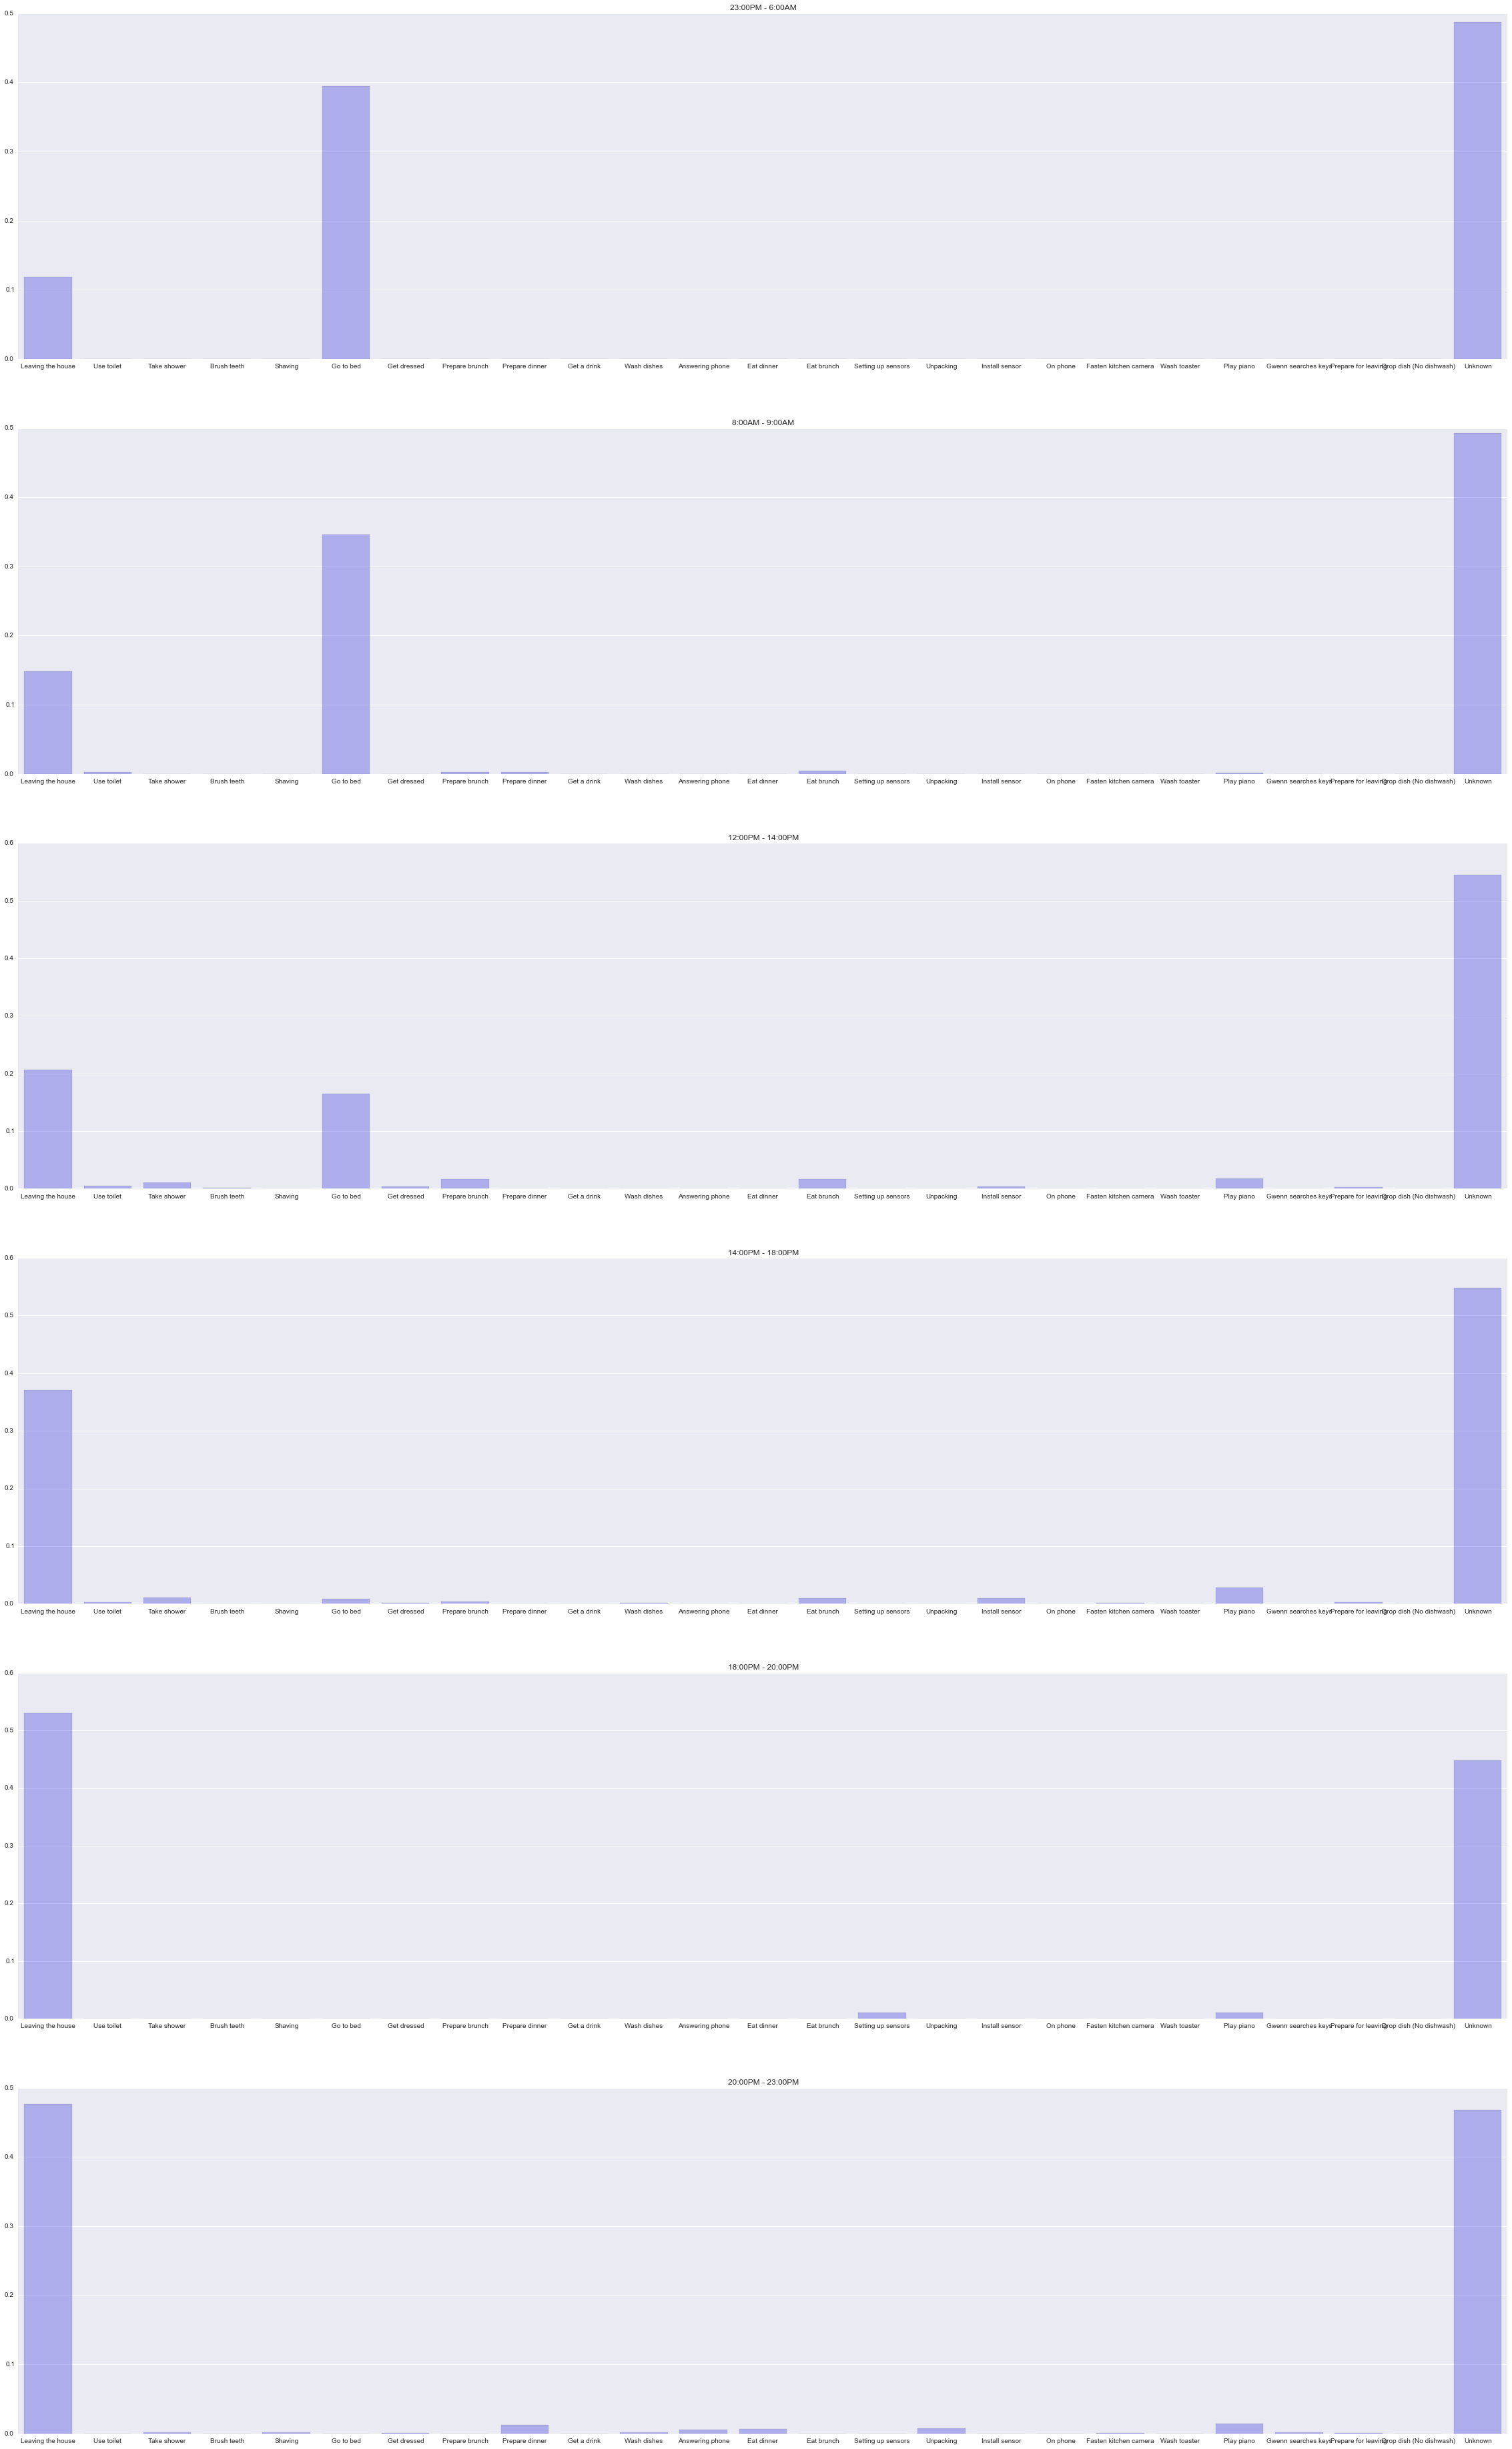

In [21]:
acts = np.arange(num_act)
fig, ax = plt.subplots(6,1,figsize = (40,65))
zero_start = first_time_dict[0]
six_am_prior = np.mean(priorB[zero_start + 23*HOUR:zero_start + DAY + 6*HOUR], axis = 0)
sns.barplot(acts,np.mean(priorB[zero_start + 7*HOUR:zero_start + 8*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[0])
sns.barplot(acts,np.mean(priorB[zero_start + 10*HOUR:zero_start + 12*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[1])
sns.barplot(acts,np.mean(priorB[zero_start + 12*HOUR:zero_start + 14*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[2])
sns.barplot(acts,np.mean(priorB[zero_start + 14*HOUR:zero_start + 18*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[3])
sns.barplot(acts,np.mean(priorB[zero_start + 18*HOUR:zero_start + 20*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[4])
sns.barplot(acts,np.mean(priorB[zero_start + 20*HOUR:zero_start + 23*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[5])

#print [list(i)[0] if i is not None else 'Unkown' for i in i2m.values()]
ticklist = []
for i in i2m.values():
    if i:
        ticklist.append(list(i)[0])
    else:
        ticklist.append('Unknown')

for i in range(6):
    ax[i].set_xticklabels(ticklist)
ax[0].set_title('23:00PM - 6:00AM')
ax[1].set_title('8:00AM - 9:00AM')
ax[2].set_title('12:00PM - 14:00PM')
ax[3].set_title('14:00PM - 18:00PM')
ax[4].set_title('18:00PM - 20:00PM')
ax[5].set_title('20:00PM - 23:00PM')


## Plot Prior B, Day

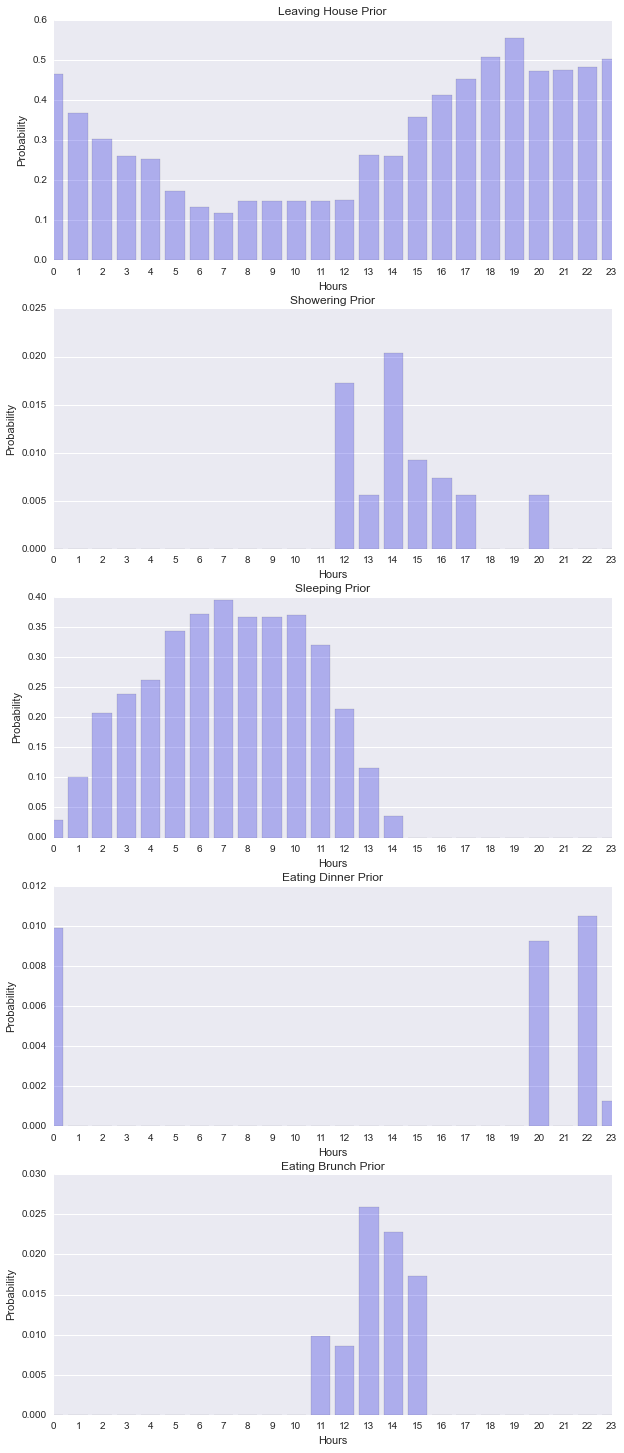

In [22]:
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
zero_start = first_time_dict[0]
day_leaving = priorB[:,0][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_leaving = np.mean(day_leaving,axis=1)
sns.barplot(day1,day_hourly_leaving,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Leaving House Prior')

day_showering = priorB[:,2][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorB[:,5][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_eat_dinner = priorB[:,12][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat_dinner = np.mean(day_eat_dinner,axis=1)
sns.barplot(day1,day_hourly_eat_dinner,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Eating Dinner Prior')

day_eat_brunch = priorB[:,13][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat_brunch = np.mean(day_eat_brunch,axis=1)
sns.barplot(day1,day_hourly_eat_brunch,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Eating Brunch Prior')


In [27]:
np.save('data/Prior_B',priorB)

# Prior C

In [30]:
act_df,sensor_df,X,Y = read_data('C', 'r')
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
i2m = {}
for i in range(len(all_act)):
    i2m[i] = set(list(act_df[act_df['label']==i2a[i]]['meaning']))

In [28]:
# Prior C
num_t = len(X)
num_act = len(all_act)
HOUR = 60
MINUTE = 60
DAY = 60 * 24
first_six_am = 1227157200
first_time_dict = {}


for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
    elif first_time_dict[i] > 60*24:
        first_time_dict[i] -= 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}


priorC = np.zeros((DAY,num_act))


reshape_shape = [num_t/DAY,DAY]
used_t = num_t/DAY*DAY
remain_t = num_t - used_t

used_Y = Y[:used_t]
remain_Y = Y[used_t:]
print "Used {} minutes, remains {} minutes, total {} minutes".format(used_Y.shape[0], remain_Y.shape[0], Y.shape[0])
used_Y = used_Y.reshape(reshape_shape)
for i in range(used_Y.shape[1]):
    day_activity = used_Y[:,i]

    unique, counts = np.unique(day_activity, return_counts=True)

    if i < remain_t:
        if remain_Y[i] in unique:

            counts[int(np.where(unique==remain_Y[i])[0])]+=1

        else:
            np.append(unique,int(remain_Y[i]))
            np.append(counts,1)

        for j,k in enumerate(unique):
            priorC[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0])+1)
    else:
        for j,k in enumerate(unique):
            priorC[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0]))


priorC = np.tile(priorC,(num_t/DAY,1))
priorC = np.vstack((priorC, priorC[0:remain_t]))


Used 25920 minutes, remains 568 minutes, total 26488 minutes


## Plot Prior A, Time interval

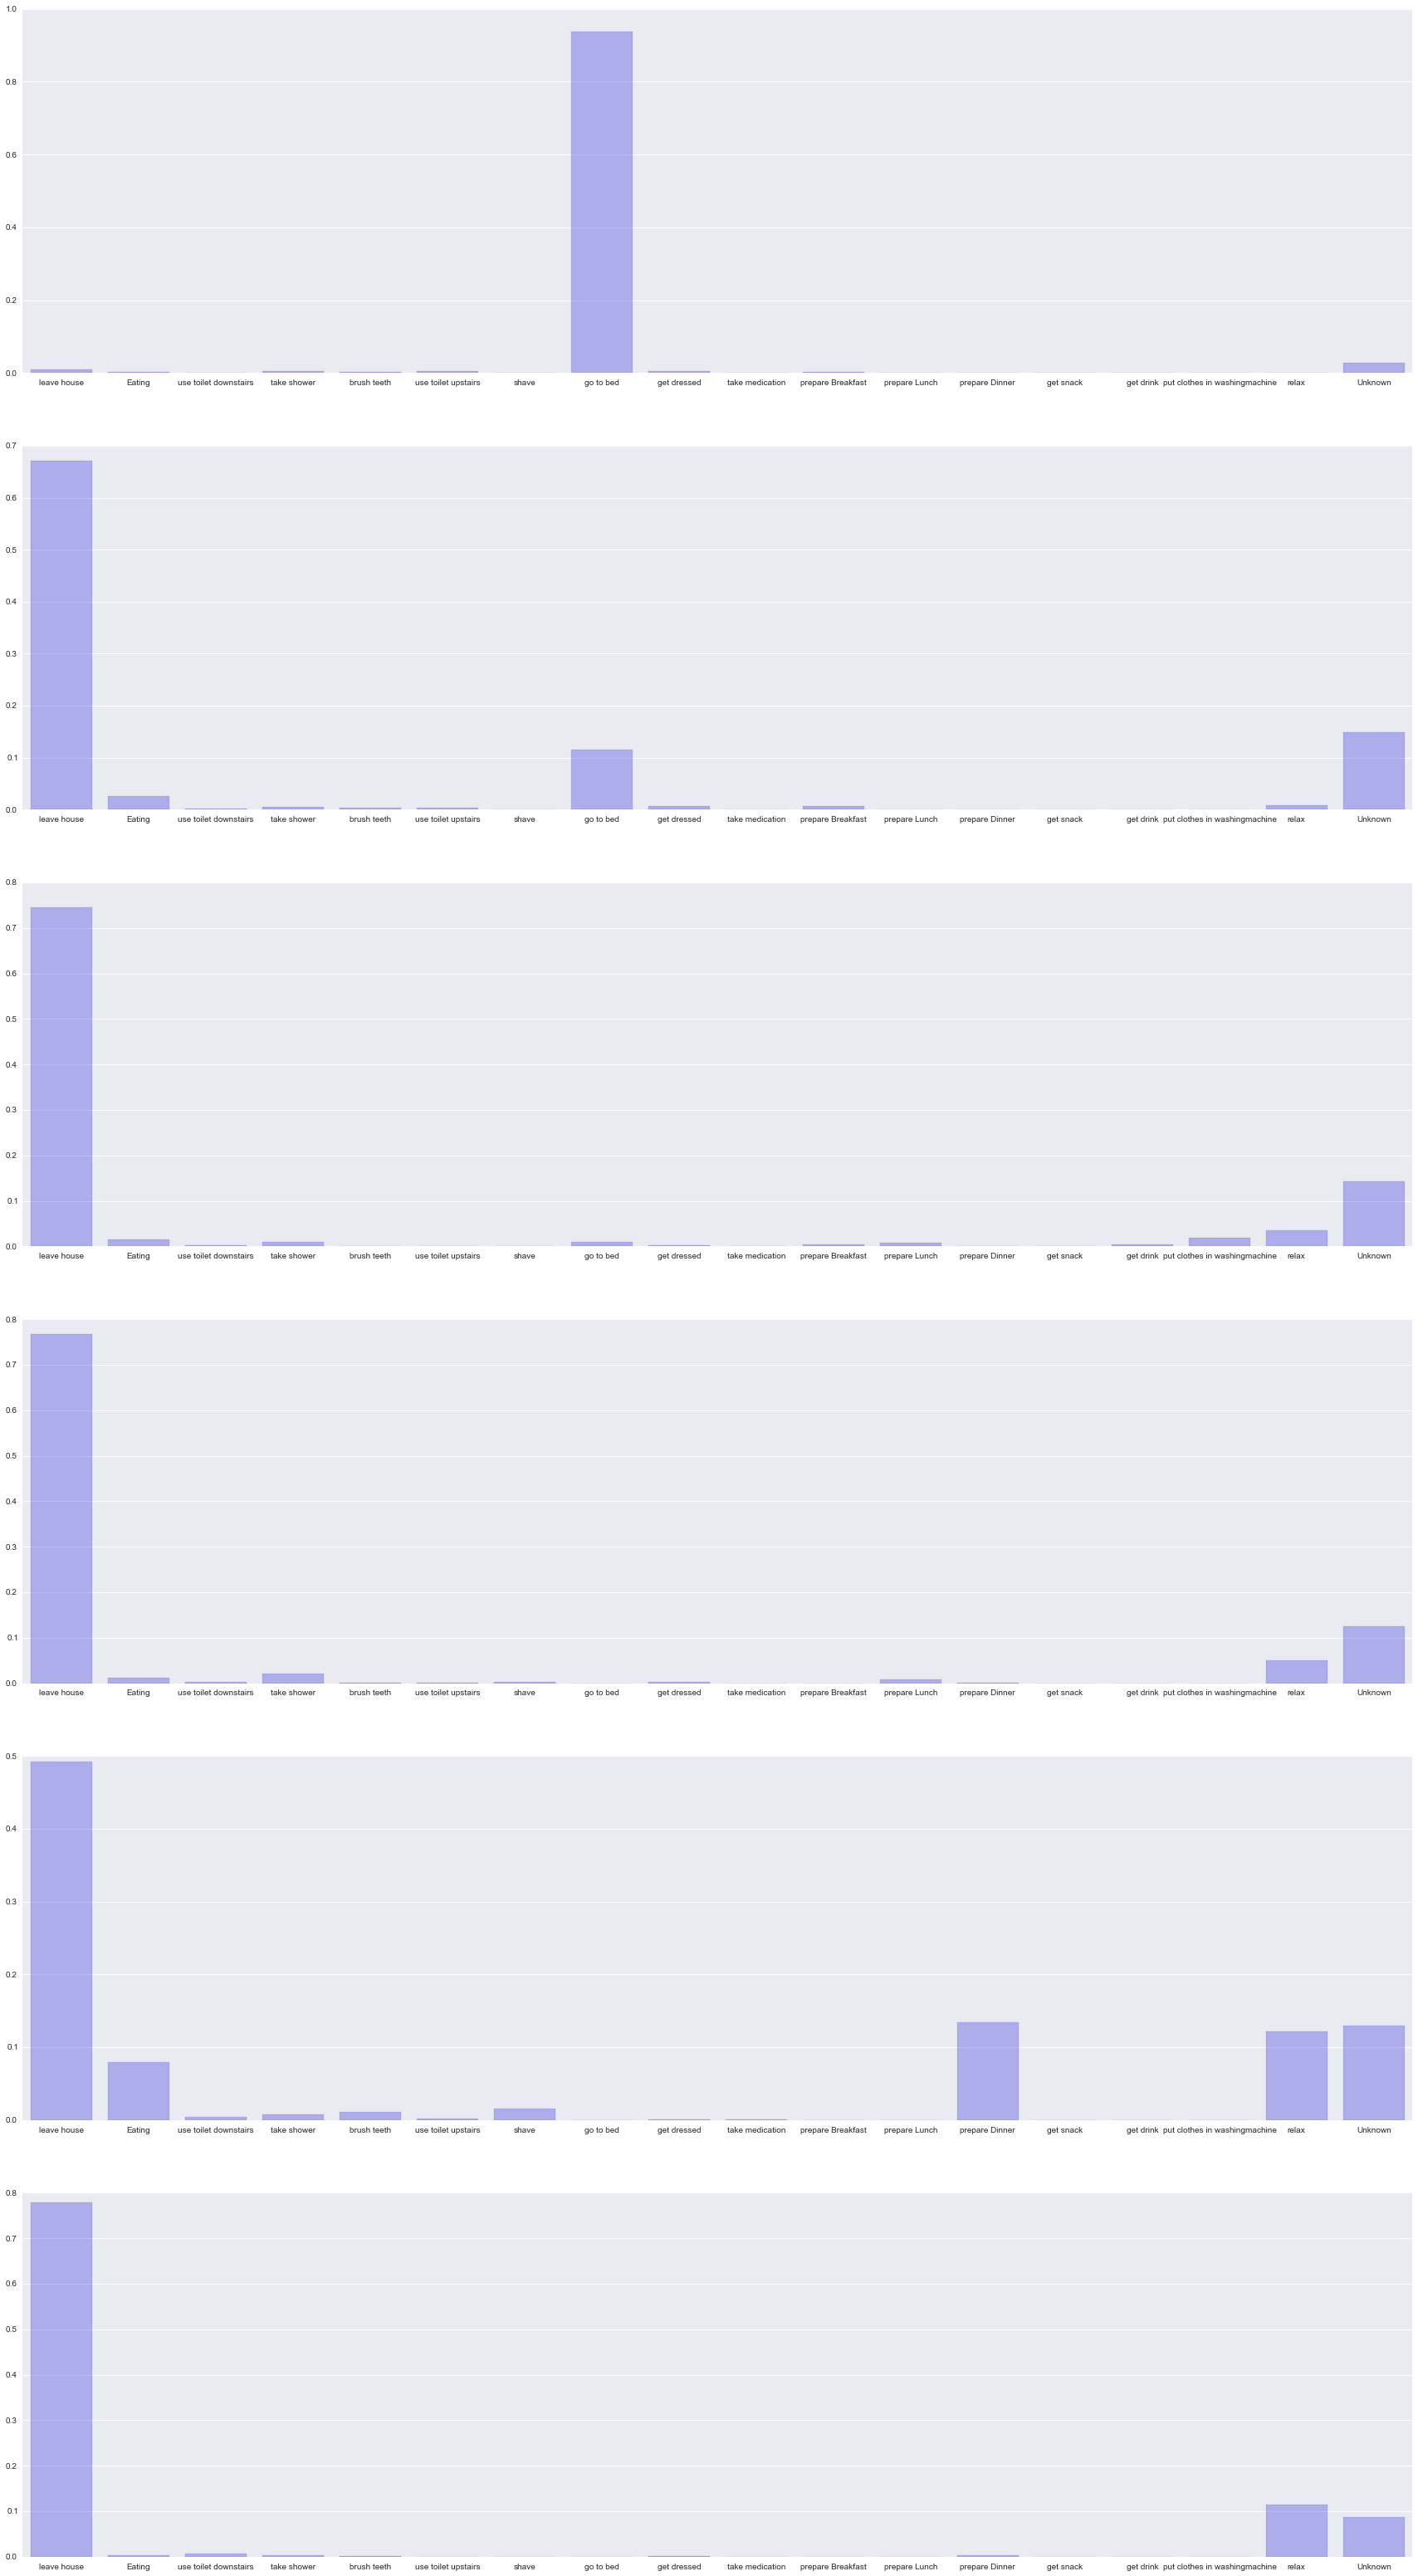

In [29]:
acts = np.arange(num_act)
fig, ax = plt.subplots(6,1,figsize = (30,55))
zero_start = first_time_dict[0]
six_am_prior = np.mean(priorC[zero_start + 23*HOUR:zero_start + DAY + 6*HOUR], axis = 0)
sns.barplot(acts,np.mean(priorC[zero_start + 7*HOUR:zero_start + 8*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[0])
sns.barplot(acts,np.mean(priorC[zero_start + 10*HOUR:zero_start + 12*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[1])
sns.barplot(acts,np.mean(priorC[zero_start + 12*HOUR:zero_start + 14*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[2])
sns.barplot(acts,np.mean(priorC[zero_start + 14*HOUR:zero_start + 18*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[3])
sns.barplot(acts,np.mean(priorC[zero_start + 18*HOUR:zero_start + 20*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[4])
sns.barplot(acts,np.mean(priorC[zero_start + 20*HOUR:zero_start + 23*HOUR], axis = 0),color='b',alpha = 0.3,ax = ax[5])

ticklist = []
for i in i2m.values():
    if i:
        ticklist.append(list(i)[0])
    else:
        ticklist.append('Unknown')
for i in range(6):
    ax[i].set_xticklabels(ticklist)

In [31]:
i2m

{0: {'leave house'},
 1: {'Eating'},
 2: {'use toilet downstairs'},
 3: {'take shower'},
 4: {'brush teeth'},
 5: {'use toilet upstairs'},
 6: {'shave'},
 7: {'go to bed'},
 8: {'get dressed'},
 9: {'take medication'},
 10: {'prepare Breakfast'},
 11: {'prepare Lunch'},
 12: {'prepare Dinner'},
 13: {'get snack'},
 14: {'get drink'},
 15: {'put clothes in washingmachine'},
 16: {'relax'},
 17: set()}

## Plot Prior C, Day

12


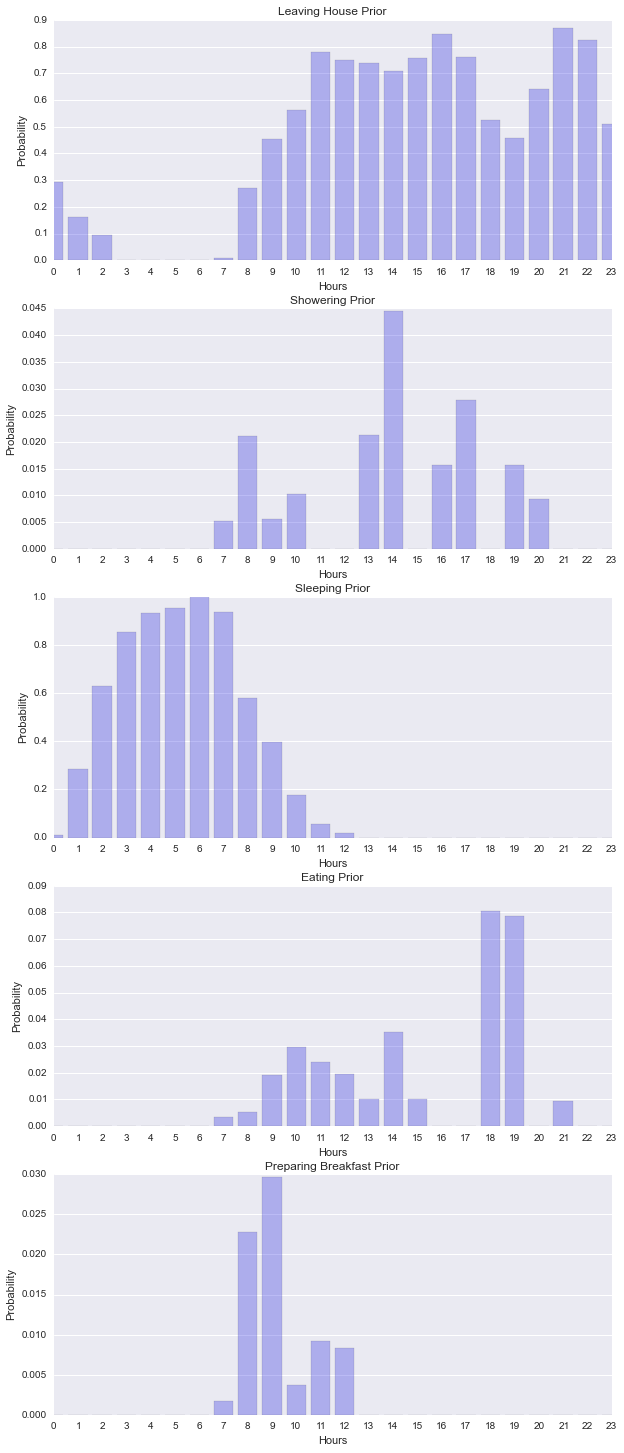

In [31]:
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
zero_start = first_time_dict[0]
print zero_start
day_leaving = priorC[:,0][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_leaving = np.mean(day_leaving,axis=1)
#day_hourly_leaving = np.roll(day_hourly_leaving,0)
sns.barplot(day1,day_hourly_leaving,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Leaving House Prior')

#take shower
day_showering = priorC[:,3][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
#day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorC[:,7][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
#day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_eat = priorC[:,1][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat = np.mean(day_eat,axis=1)
#day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_eat,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Eating Prior')

day_prepare_breakfast = priorC[:,10][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_prepare_breakfast = np.mean(day_prepare_breakfast,axis=1)
#day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_prepare_breakfast,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Preparing Breakfast Prior')


In [32]:
np.save('data/Prior_A.npy',priorA)
np.save('data/Prior_B.npy',priorB)
np.save('data/Prior_C.npy',priorC)